In [46]:
!sudo apt-get update --fix-missing
!sudo apt install graphviz -y
!pip install pydot optuna

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]        
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease    
Hit:5 http://security.ubuntu.com/ubuntu focal-security InRelease    
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Fetched 128 kB in 1s (154 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 145 not upgraded.

[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [47]:
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow import keras
import optuna

gpus = tf.config.list_physical_devices('GPUS')
if gpus:
    try:
        tf.config.set_logical_device_configuration(gpus[0],[tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        os.environ['TF_GPU_ALLOCATION'] = "cuda_malloc_async"
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs detected!!!")
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'

No GPUs detected!!!


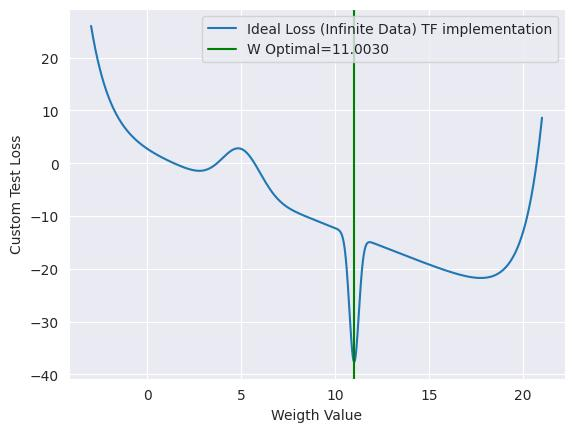

<Figure size 640x480 with 0 Axes>

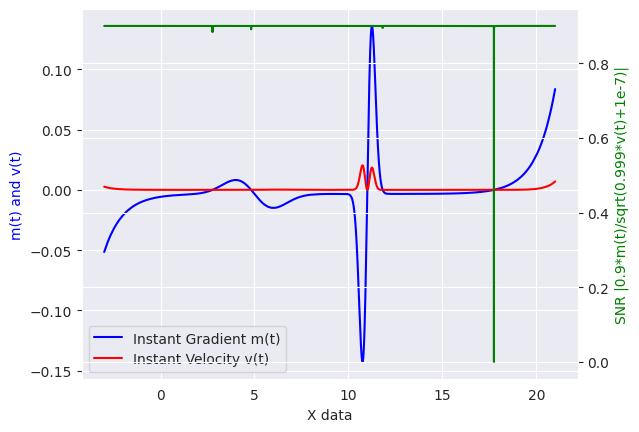

In [68]:
def G(x,mean, variance):
     return np.exp(-np.square(x-mean)/2*variance)/(np.sqrt(2*np.pi*variance))

def custom_loss(x):
    y=np.exp(-x) +0.09*np.exp(-15+x) -0.1*np.abs(x+17) -200*G(x,8,10) + 10*G(x,15,1)
    return y

def custom_loss_tf(x):
    y=tf.math.exp(-x) - 1.5*x
    y = tf.add(y,tf.multiply(0.09,tf.math.exp(tf.add(-15.0,x))))
    y  = tf.subtract(y,tf.multiply(-0.1,tf.abs(tf.add(x,17.0))))
    y  = tf.subtract(y,tf.multiply(15.,tfd.Normal(loc=11., scale=0.25).prob(x)))
    y  = tf.add(y,tf.multiply(20.,tfd.Normal(loc=5., scale=1.).prob(x)))  
    return y

N=10000
x=np.linspace(-3,21,N)
y,dy=custom_loss_tf(tf.constant(x,dtype=tf.float32))
y2=custom_loss(x)
TRUE_W = x[np.argmin(y)]
plt.figure()
w=20

for _ in range(1):
    noisy=y+np.random.normal(0, 0.25, N)
    #noisy = signal.filtfilt(1/(w*np.ones(w)), 1, noisy)
    #plt.plot(x,noisy,c='r',alpha=0.75,label='Batch Loss')
plt.plot(x,y,label='Ideal Loss (Infinite Data) TF implementation')
#plt.plot(x,y2,label='Ideal Loss (Infinite Data)',c='r')
plt.axvline(TRUE_W,c='g',label='W Optimal=%0.4f'%TRUE_W)
plt.xlabel('Weigth Value')
plt.ylabel('Custom Test Loss')
plt.legend()
plt.show()

In [49]:
class LastSample(keras.metrics.Metric):
    def __init__(self, name='sample', **kwargs):
        super().__init__(name=name, **kwargs)
        self.sample = self.add_variable(shape=(),initializer='zeros',name='sample')
    def update_state(self, y):
        self.sample.assign(y)
    def result(self):
        return self.sample

class CustomModel(keras.Model):
    def __init__(self,loss_func, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker = LastSample(name="loss")
        self.w_metric = LastSample(name="weight")
        self.momentum = LastSample(name="momentum")
        self.velocity = LastSample(name="velocity")
        self.loss_func=loss_func

    def train_step(self, data):
        trainable_vars = self.trainable_variables
        self.w_metric.update_state(tf.squeeze(trainable_vars[0]))
        with tf.GradientTape() as tape:
            loss = self.loss_func(tf.squeeze(trainable_vars[0]))
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_tracker.update_state(tf.squeeze(loss))

        #print(self.optimizer.variables()[1])
        self.momentum.update_state(tf.squeeze(self.optimizer.variables()[1]))
        self.velocity.update_state(tf.squeeze(self.optimizer.variables()[2]))

        return {"loss": self.loss_tracker.result(), "weight": self.w_metric.result(), "momentum":self.momentum.result(), "velocity":self.velocity.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.w_metric, self.momentum, self.velocity]


def run(optimizer,seed=0,loss_func=None):
    initalizer=tf.keras.initializers.GlorotUniform(seed)
    inputs = keras.Input(shape=(1,))
    outputs = keras.layers.Dense(1,use_bias=False,kernel_initializer=initalizer)(inputs)
    model = CustomModel(loss_func,inputs, outputs)
    xtrain = np.random.random((1, 1))*0
    ytrain = xtrain*TRUE_W
    model.compile(optimizer=optimizer,run_eagerly=False)
    history = model.fit(xtrain, ytrain, epochs=100,verbose=0,batch_size=128)
    return history

In [50]:
best=(np.inf,None,None,None)
for _,epsilon in enumerate([1e-8,1e-7,1e-6]):
    fig=plt.figure(figsize=(16, 10))
    losses={}
    momentum={}
    velocity={}
    count=0
    for i,beta_1 in enumerate([0.9, 1.,  0.5 ,0]):
        for k,beta_2 in enumerate([0.999, 1., 0.5 ,0]):
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.2,beta_1=beta_1, beta_2=beta_2,epsilon=epsilon)
            history = run(optimizer=optimizer,loss_func=custom_loss_tf)
            if i==0 and k==0:
                plt.title("Epsilon %0.4f"%epsilon)
            plt.subplot(4*2,4,i*4*2+k+1)
            plt.plot(x,y)
            plt.plot(history.history['weight'],history.history['loss'],c='r',marker='o',label='b1=%0.3f b2=%0.3f'%(beta_1,beta_2),alpha=0.5)
            plt.plot(history.history['weight'][0],history.history['loss'][0],c='g',marker='o')
            plt.plot(history.history['weight'][-1],history.history['loss'][-1],c='y',marker='o')
            plt.xlim([np.min(x),np.max(x)])
            plt.xlabel('Weigth Value')
            plt.ylabel('Custom Test Loss')
            plt.legend()

            plt.subplot(4*2,4,i*4*2+k+1+4)
            plt.plot(history.history['loss'])
            #plt.ylim([np.min(y),np.max(y)])
            plt.ylabel("Loss")
            plt.xlabel("Epoch")
            if history.history['loss'][-1]<best[0]:
                print("b1=%s b2=%s epsilon=%s"%(beta_1,beta_2,epsilon))
                print(history.history['loss'][-1])
                best=(history.history['loss'][-1],beta_1,beta_2,epsilon)
            losses[count]=history.history['loss']
            momentum[count]=history.history['momentum']
            velocity[count]=history.history['velocity']

            count+=1
fig.tight_layout()
print(best)

/tmp/ipykernel_13/1328969923.py:4: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self.sample = self.add_variable(shape=(),initializer='zeros',name='sample')


StagingError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/tmp/ipykernel_13/1328969923.py", line 23, in train_step
        loss = self.loss_func(tf.squeeze(trainable_vars[0]))
    File "/tmp/ipykernel_13/1561328672.py", line 14, in custom_loss_tf
        ys= tf.concat([[0],tf.slice(y,[0],[y.shape[0]-1])],axis=0)

    IndexError: tuple index out of range


<Figure size 1600x1000 with 0 Axes>

In [ ]:
def get_params(trial):
    params = {"lr": trial.suggest_float("lr", 1e-3, 1),
              "beta_1": trial.suggest_float("beta_1",0.5,0.99),
              "beta_2": trial.suggest_categorical("beta_2",[0,0.1]),
              "epsilon":trial.suggest_categorical("epsilon",[1e-8,1e-7,1e-6,1e-5]),
              "seed":trial.suggest_categorical("seed",[0,1,2,3,4,5,6,7,8,9]),
              }
    return params

def get_objective():
    def objective(trial):
        params = get_params(trial)
        optimizer=tf.keras.optimizers.Adam(learning_rate=params['lr'],beta_1=params['beta_1'],beta_2=params['beta_2'],epsilon=params['epsilon'])
        history = run(optimizer=optimizer,seed=params['seed'],loss_func=custom_loss_tf)
        score=history.history['loss'][-1]
        score = 30 if np.isnan(score) else score
        return score
    return objective

def optuna_tuner(optuna_trials=100):
    n_startup_trials=50
    sampler = optuna.samplers.TPESampler(seed=10, n_startup_trials=n_startup_trials,consider_endpoints=True,multivariate=True)
    study = optuna.create_study(sampler=sampler, direction="minimize")
    objective = get_objective()
    study.optimize(objective, n_trials=optuna_trials)
    trial = study.best_trial
    print("**"*50 + " Finished Optimizing")
    print("Number of finished trials: ", len(study.trials))
    print("  Value: {}".format(trial.value))
    print("Best  Params: %s" % str(trial.params))
    results=trial.params.copy()
    return results

best_params = optuna_tuner(optuna_trials=100)

In [ ]:
plt.figure(figsize=(16, 10))
history = run(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['lr'],beta_1=best_params['beta_1'],
                                                 beta_2=best_params['beta_2'],epsilon=best_params['epsilon']),
                                                seed=best_params['seed'],
                                                loss_func=custom_loss_tf)
print(history.history['loss'][-1])
plt.subplot(2,1,1)
plt.plot(x,y)
plt.plot(history.history['weight'],history.history['loss'],c='r',marker='o',label='best params'%(best_params),alpha=0.5)
plt.plot(history.history['weight'][0],history.history['loss'][0],c='g',marker='o')
plt.plot(history.history['weight'][-1],history.history['loss'][-1],c='y',marker='o')
plt.xlim([np.min(x),np.max(x)])
plt.xlabel('Weigth Value')
plt.ylabel('Custom Test Loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
#plt.ylim([np.min(y),np.max(y)])
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [ ]:
def get_params(trial):
    params = {"lr": trial.suggest_float("lr", 1e-3, 1),
              "beta_1": trial.suggest_float("beta_1",0.5,0.99),
              "beta_2": trial.suggest_categorical("beta_2",[0,0.1]),
              "epsilon":trial.suggest_categorical("epsilon",[1e-8,1e-7,1e-6,1e-5]),
              "seed":trial.suggest_categorical("seed",[0,1,2,3,4,5,6,7,8,9]),
              }
    return params

def get_objective():
    def objective(trial):
        params = get_params(trial)
        learning_rate=tf.keras.optimizers.schedules.CosineDecayRestarts(params['lr'],10)
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=params['beta_1'],beta_2=params['beta_2'],epsilon=params['epsilon'])
        history = run(optimizer=optimizer,loss_func=custom_loss_tf)
        score=history.history['loss'][-1]
        score = 30 if np.isnan(score) else score
        return score
    return objective

def optuna_tuner(optuna_trials=100):
    n_startup_trials=50
    sampler = optuna.samplers.TPESampler(seed=10, n_startup_trials=n_startup_trials,consider_endpoints=True,multivariate=True)
    study = optuna.create_study(sampler=sampler, direction="minimize")
    objective = get_objective()
    study.optimize(objective, n_trials=optuna_trials)
    trial = study.best_trial
    print("**"*50 + " Finished Optimizing")
    print("Number of finished trials: ", len(study.trials))
    print("  Value: {}".format(trial.value))
    print("Best  Params: %s" % str(trial.params))
    results=trial.params.copy()
    return results

best_params = optuna_tuner(optuna_trials=100)

In [ ]:
plt.figure(figsize=(16, 10))
learning_rate=tf.keras.optimizers.schedules.CosineDecayRestarts(best_params['lr'],10)
history = run(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=best_params['beta_1'],
                                                 beta_2=best_params['beta_2'],epsilon=best_params['epsilon']),seed=best_params['seed'],loss_func=custom_loss_tf)
print(best_params)
print(history.history['loss'][-1])
plt.subplot(2,1,1)
plt.plot(x,y)
plt.plot(history.history['weight'],history.history['loss'],c='r',marker='o',label='best params'%(best_params),alpha=0.5)
plt.plot(history.history['weight'][0],history.history['loss'][0],c='g',marker='o')
plt.plot(history.history['weight'][-1],history.history['loss'][-1],c='y',marker='o')
plt.xlim([np.min(x),np.max(x)])
plt.xlabel('Weigth Value')
plt.ylabel('Custom Test Loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
#plt.ylim([np.min(y),np.max(y)])
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [ ]:
#Loss with Noise
def custom_loss_tf2(x):
    y=tf.math.exp(-x) - 1.5*x
    y = tf.add(y,tf.multiply(0.09,tf.math.exp(tf.add(-15.0,x))))
    y  = tf.subtract(y,tf.multiply(-0.1,tf.abs(tf.add(x,17.0))))
    y  = tf.subtract(y,tf.multiply(15.,tfd.Normal(loc=11., scale=0.25).prob(x)))
    y  = tf.add(y,tf.multiply(20.,tfd.Normal(loc=5., scale=1.).prob(x)))
    y  = tf.add(y,tfd.LogNormal(loc=0., scale=0.5).sample(sample_shape=y.shape,seed=0))
    return y

N=10000
x=np.linspace(-3,21,N)
y=custom_loss_tf2(tf.constant(x,dtype=tf.float32))
TRUE_W = x[np.argmin(y)]
plt.figure()
w=20
plt.plot(x,y,label='Ideal Loss (Infinite Data) TF implementation')
plt.axvline(TRUE_W,c='g',label='W Optimal=%0.4f'%TRUE_W)
plt.xlabel('Weigth Value')
plt.ylabel('Custom Test Loss')
plt.legend()
plt.show()


In [ ]:
best=(np.inf,None,None,None)
for _,epsilon in enumerate([1e-8,1e-7,1e-6]):
    fig=plt.figure(figsize=(16, 12))
    for i,beta_1 in enumerate([0.9, 1.,  0.5 ,0]):
        for k,beta_2 in enumerate([0.999, 1., 0.5 ,0]):
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.2,beta_1=beta_1, beta_2=beta_2,epsilon=epsilon)
            history = run(optimizer=optimizer,loss_func=custom_loss_tf2)
            if i==0 and k==0:
                plt.title("Epsilon %0.4f"%epsilon)
            plt.subplot(4*2,4,i*4*2+k+1)
            plt.plot(x,y)
            plt.plot(history.history['weight'],history.history['loss'],c='r',marker='o',label='b1=%0.3f b2=%0.3f'%(beta_1,beta_2),alpha=0.5)
            plt.plot(history.history['weight'][0],history.history['loss'][0],c='g',marker='o')
            plt.plot(history.history['weight'][-1],history.history['loss'][-1],c='y',marker='o')
            plt.xlim([np.min(x),np.max(x)])
            plt.xlabel('Weigth Value')
            plt.ylabel('Custom Test Loss')
            plt.legend()

            plt.subplot(4*2,4,i*4*2+k+1+4)
            plt.plot(history.history['loss'])
            plt.ylim([np.min(y),np.max(y)])
            plt.ylabel("Loss")
            plt.xlabel("Epoch")
            if history.history['loss'][-1]<best[0]:
                print("b1=%s b2=%s epsilon=%s"%(beta_1,beta_2,epsilon))
                print(history.history['loss'][-1])
                best=(history.history['loss'][-1],beta_1,beta_2,epsilon)
    fig.tight_layout()
print(best)

In [ ]:
def get_objective():
    def objective(trial):
        params = get_params(trial)
        optimizer=tf.keras.optimizers.Adam(learning_rate=params['lr'],beta_1=params['beta_1'],beta_2=params['beta_2'],epsilon=params['epsilon'])
        history = run(optimizer=optimizer,seed=params['seed'],loss_func=custom_loss_tf2)
        score=history.history['loss'][-1]
        score = 30 if np.isnan(score) else score
        return score
    return objective

def optuna_tuner(optuna_trials=100):
    n_startup_trials=50
    sampler = optuna.samplers.TPESampler(seed=10, n_startup_trials=n_startup_trials,consider_endpoints=True,multivariate=True)
    study = optuna.create_study(sampler=sampler, direction="minimize")
    objective = get_objective()
    study.optimize(objective, n_trials=optuna_trials)
    trial = study.best_trial
    print("**"*50 + " Finished Optimizing")
    print("Number of finished trials: ", len(study.trials))
    print("  Value: {}".format(trial.value))
    print("Best  Params: %s" % str(trial.params))
    results=trial.params.copy()
    return results

best_params = optuna_tuner(optuna_trials=100)

In [ ]:
plt.figure(figsize=(16, 10))
history = run(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['lr'],beta_1=best_params['beta_1'],
                                                 beta_2=best_params['beta_2'],epsilon=best_params['epsilon']),
                                                seed=best_params['seed'],
                                                loss_func=custom_loss_tf2)
print(history.history['loss'][-1])
plt.subplot(2,1,1)
plt.plot(x,y)
plt.plot(history.history['weight'],history.history['loss'],c='r',marker='o',label='best params'%(best_params),alpha=0.5)
plt.plot(history.history['weight'][0],history.history['loss'][0],c='g',marker='o')
plt.plot(history.history['weight'][-1],history.history['loss'][-1],c='y',marker='o')
plt.xlim([np.min(x),np.max(x)])
plt.xlabel('Weigth Value')
plt.ylabel('Custom Test Loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
#plt.ylim([np.min(y),np.max(y)])
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [ ]:
def get_params(trial):
    params = {"lr": trial.suggest_float("lr", 1e-3, 1),
              "beta_1": trial.suggest_float("beta_1",0.5,0.99),
              "beta_2": trial.suggest_categorical("beta_2",[0,0.1,0.5,0.999]),
              "epsilon":trial.suggest_categorical("epsilon",[1e-8,1e-7,1e-6,1e-5]),
              "seed":trial.suggest_categorical("seed",[0,1,2,3,4,5,6,7,8,9]),
              }
    return params

def get_objective():
    def objective(trial):
        params = get_params(trial)
        learning_rate=tf.keras.optimizers.schedules.CosineDecayRestarts(params['lr'],2)
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=params['beta_1'],beta_2=params['beta_2'],epsilon=params['epsilon'])
        history = run(optimizer=optimizer,loss_func=custom_loss_tf2)
        score=history.history['loss'][-1]
        score = 30 if np.isnan(score) else score
        return score
    return objective

def optuna_tuner(optuna_trials=100):
    n_startup_trials=50
    sampler = optuna.samplers.TPESampler(seed=10, n_startup_trials=n_startup_trials,consider_endpoints=True,multivariate=True)
    study = optuna.create_study(sampler=sampler, direction="minimize")
    objective = get_objective()
    study.optimize(objective, n_trials=optuna_trials)
    trial = study.best_trial
    print("**"*50 + " Finished Optimizing")
    print("Number of finished trials: ", len(study.trials))
    print("  Value: {}".format(trial.value))
    print("Best  Params: %s" % str(trial.params))
    results=trial.params.copy()
    return results

best_params = optuna_tuner(optuna_trials=100)

In [ ]:
plt.figure(figsize=(16, 10))
learning_rate=tf.keras.optimizers.schedules.CosineDecayRestarts(best_params['lr'],2)
history = run(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=best_params['beta_1'],
                                                 beta_2=best_params['beta_2'],epsilon=best_params['epsilon']),seed=best_params['seed'],loss_func=custom_loss_tf2)
print(best_params)
print(history.history['loss'][-1])
plt.subplot(2,1,1)
plt.plot(x,y)
plt.plot(history.history['weight'],history.history['loss'],c='r',marker='o',label='best params'%(best_params),alpha=0.5)
plt.plot(history.history['weight'][0],history.history['loss'][0],c='g',marker='o')
plt.plot(history.history['weight'][-1],history.history['loss'][-1],c='y',marker='o')
plt.xlim([np.min(x),np.max(x)])
plt.xlabel('Weigth Value')
plt.ylabel('Custom Test Loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Time to 10% decay (in Epochs)')

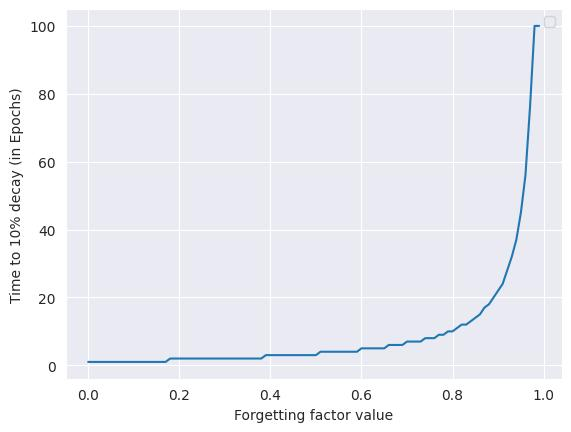

In [52]:
#Plot to understand forgetting factor
data=[]
p=np.arange(0,1,0.01)
x=np.arange(0,101,1)
for po in p:
    y=[1]
    for _ in range(100):
        ynew=po * y[-1] + (1 - po) * 0
        #ynew=po * y[-1] + (1 - po) * 1
        y.append(ynew)
    area=np.array(y) #cumsum(y/sum(y))
    data.append(np.argmin(np.abs(area-0.1)))

plt.figure()
plt.plot(p,data)
#plt.vlines(p[90],0,20,color='r',label='p=%0.3f'%p[90])
plt.legend()
plt.xlabel("Forgetting factor value")
plt.ylabel("Time to 10% decay (in Epochs)")

In [63]:
y9=[1]
p=0.999
for _ in range(10000):
    ynew=p * y9[-1] + (1 - p) * 0
    y9.append(ynew)
ind=np.argmin(np.abs(np.array(y9)-0.1))
print(ind)
print(y9[ind])

2301
0.10004339195341891


In [ ]:
area=np.cumsum(y/sum(y))
np.argmin(np.abs(area-0.9))